In [1]:
import os, shutil

In [2]:
base_dir = '/home/skhatter/rooftop_damage_data/'
train_dir = '/home/skhatter/rooftop_damage_data/train'
valid_dir = '/home/skhatter/rooftop_damage_data/val'
test_dir = '/home/skhatter/rooftop_damage_data/test'


train_dam_dir = '/home/skhatter/rooftop_damage_data/train/wind_damaged'
train_undam_dir = '/home/skhatter/rooftop_damage_data/train/undamaged'
train_obj_dir = '/home/skhatter/rooftop_damage_data/train/object' 
train_notroof_dir = '/home/skhatter/rooftop_damage_data/train/not_roof'

valid_dam_dir = '/home/skhatter/rooftop_damage_data/val/wind_damaged'
valid_undam_dir = '/home/skhatter/rooftop_damage_data/val/undamaged'
valid_obj_dir = '/home/skhatter/rooftop_damage_data/val/object'
valid_notroof_dir = '/home/skhatter/rooftop_damage_data/val/not_roof'

In [3]:
print('Total training wind damaged images', len(os.listdir(train_dam_dir)))
print('Total training undamaged images', len(os.listdir(train_undam_dir)))
print('Total training object images', len(os.listdir(train_obj_dir)))
print('Total training not-roof images', len(os.listdir(train_notroof_dir)))


print('Total validation wind damaged images', len(os.listdir(valid_dam_dir)))
print('Total validation undamaged images', len(os.listdir(valid_undam_dir)))
print('Total validation object images', len(os.listdir(valid_obj_dir)))
print('Total validation notroof images', len(os.listdir(valid_notroof_dir)))


print('Total test damaged images', len(os.listdir(test_dir)))

('Total training wind damaged images', 27914)
('Total training undamaged images', 38020)
('Total training object images', 3668)
('Total training not-roof images', 34536)
('Total validation wind damaged images', 99)
('Total validation undamaged images', 163)
('Total validation object images', 9)
('Total validation notroof images', 173)
('Total test damaged images', 10)


In [4]:
from keras import layers
from keras import models
from keras.applications import InceptionV3

Using TensorFlow backend.


In [5]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(512, 512, 3))
conv_base.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 255, 255, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 255, 255, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 255, 255, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

In [7]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'conv2d_91':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               102760704 
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 124,564,516
Trainable params: 107,130,884
Non-trainable params: 17,433,632
_________________________________________________________________


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255)


train_generator = datagen.flow_from_directory(train_dir,
                                             target_size = (512, 512), 
                                              batch_size = 20,
                                              class_mode = 'categorical')


validation_generator = datagen.flow_from_directory(valid_dir,
                                             target_size = (512, 512), 
                                              batch_size = 20,
                                              class_mode = 'categorical')
                                              

Found 104138 images belonging to 4 classes.
Found 444 images belonging to 4 classes.


In [10]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=1000,
                    epochs=5,  
                    validation_data=validation_generator,
                   validation_steps = 500)

Epoch 1/5
1000/1000 [==============================] - 657s - loss: 5.3601 - categorical_accuracy: 0.6219 - val_loss: 0.0843 - val_categorical_accuracy: 0.9729
Epoch 2/5
1000/1000 [==============================] - 648s - loss: 0.3677 - categorical_accuracy: 0.9209 - val_loss: 0.0571 - val_categorical_accuracy: 0.9843
Epoch 3/5
1000/1000 [==============================] - 648s - loss: 0.2992 - categorical_accuracy: 0.9360 - val_loss: 0.0859 - val_categorical_accuracy: 0.9818
Epoch 4/5
1000/1000 [==============================] - 647s - loss: 0.3012 - categorical_accuracy: 0.9437 - val_loss: 0.0724 - val_categorical_accuracy: 0.9798
Epoch 5/5
1000/1000 [==============================] - 647s - loss: 0.2961 - categorical_accuracy: 0.9480 - val_loss: 0.0711 - val_categorical_accuracy: 0.9821


In [11]:
history_dict = history.history
print(history_dict.keys())

model.save('inception_four_classes.h5')

['val_categorical_accuracy', 'loss', 'categorical_accuracy', 'val_loss']


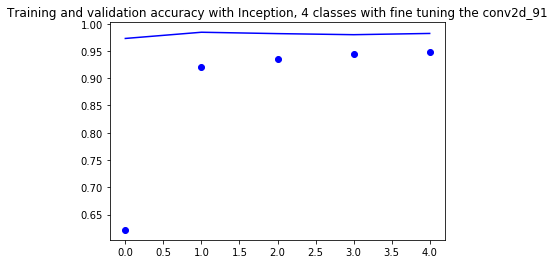

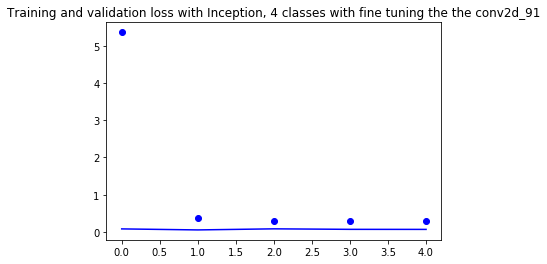

In [13]:
#Displaying curves of loss and accuracy during training 

import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')#dots
plt.plot(epochs, val_acc, 'b')#line segments
plt.title('Training and validation accuracy with Inception, 4 classes with fine tuning the conv2d_91')
plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss with Inception, 4 classes with fine tuning the the conv2d_91')
plt.show()